In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 490

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ImageFolder('/content/fer_ckplus', data_transforms['train'])
val_data = ImageFolder('/content/fer_ckplus', data_transforms['val'])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': [], 'val_loss': [], 'train_loss': [], 'lr': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)
                    results['val_loss'].append(val_loss)
                    results['train_loss'].append(train_loss)
                    results['lr'].append(get_lr(optimizer))

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation, Permute
from torchvision.ops.stochastic_depth import StochasticDepth
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import copy
import math
from torchvision.models.efficientnet import MBConvConfig, FusedMBConvConfig, _MBConvConfig

In [ ]:
#source: https://pytorch.org/vision/stable/_modules/torchvision/models/efficientnet.html
class EfficientNet(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: Sequence[Union[MBConvConfig, FusedMBConvConfig]],
        dropout: float,
        stochastic_depth_prob: float = 0.2,
        num_classes: int = 7,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        last_channel: Optional[int] = None,
    ) -> None:

        super().__init__()
        # _log_api_usage_once(self)

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, _MBConvConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[MBConvConfig]")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                1, firstconv_output_channels, kernel_size=3, stride=2, norm_layer=norm_layer, activation_layer=nn.SiLU
            )
        )

        # building inverted residual blocks
        total_stage_blocks = sum(cnf.num_layers for cnf in inverted_residual_setting)
        stage_block_id = 0
        for cnf in inverted_residual_setting:
            stage: List[nn.Module] = []
            for _ in range(cnf.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cnf = copy.copy(cnf)

                # overwrite info if not the first conv in the stage
                if stage:
                    block_cnf.input_channels = block_cnf.out_channels
                    block_cnf.stride = 1

                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = stochastic_depth_prob * float(stage_block_id) / total_stage_blocks

                stage.append(block_cnf.block(block_cnf, sd_prob, norm_layer))
                stage_block_id += 1

            layers.append(nn.Sequential(*stage))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = last_channel if last_channel is not None else 4 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.SiLU,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(lastconv_output_channels, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init_range = 1.0 / math.sqrt(m.out_features)
                nn.init.uniform_(m.weight, -init_range, init_range)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
inverted_residual_setting = [
            FusedMBConvConfig(1, 3, 1, 12, 12, 2),
            FusedMBConvConfig(4, 3, 2, 12, 24, 4),
            FusedMBConvConfig(4, 3, 2, 24, 48, 4),
            MBConvConfig(4, 3, 2, 48, 64, 6),
            MBConvConfig(6, 3, 1, 64, 128, 9),
            MBConvConfig(6, 3, 2, 128, 128, 12),
        ]
last_channel = 1024
model = EfficientNet(inverted_residual_setting, 0.2, last_channel=last_channel)

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 90
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             108
       BatchNorm2d-2           [-1, 12, 32, 32]              24
              SiLU-3           [-1, 12, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,728
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              SiLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 12, 32, 32]             192
       BatchNorm2d-8           [-1, 12, 32, 32]              24
   StochasticDepth-9           [-1, 12, 32, 32]               0
      FusedMBConv-10           [-1, 12, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           1,728
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             SiLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 12,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00004, train_loss: 2.7903, val_loss: 1.8164, val_acc: 0.1447


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00005, train_loss: 2.4554, val_loss: 1.8123, val_acc: 0.1447


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00007, train_loss: 2.3277, val_loss: 1.8063, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00009, train_loss: 2.2230, val_loss: 1.8137, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00012, train_loss: 2.1289, val_loss: 1.8120, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00015, train_loss: 2.0769, val_loss: 1.8040, val_acc: 0.1408


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00019, train_loss: 2.0213, val_loss: 1.8069, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00023, train_loss: 2.0053, val_loss: 1.7971, val_acc: 0.1451


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00028, train_loss: 1.9945, val_loss: 1.7776, val_acc: 0.1474


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00033, train_loss: 1.9531, val_loss: 1.7627, val_acc: 0.1918


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00038, train_loss: 1.8866, val_loss: 1.6195, val_acc: 0.2482


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00044, train_loss: 1.8564, val_loss: 1.5893, val_acc: 0.2720


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00049, train_loss: 1.7763, val_loss: 1.6407, val_acc: 0.2704


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00055, train_loss: 1.7416, val_loss: 1.4923, val_acc: 0.3022


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00060, train_loss: 1.7073, val_loss: 1.5325, val_acc: 0.3197
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00066, train_loss: 1.6103, val_loss: 1.8319, val_acc: 0.3295
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00071, train_loss: 1.5300, val_loss: 1.4294, val_acc: 0.3644


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00076, train_loss: 1.4698, val_loss: 1.3715, val_acc: 0.3743


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00081, train_loss: 1.4275, val_loss: 1.3771, val_acc: 0.3714


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00085, train_loss: 1.4134, val_loss: 3.1334, val_acc: 0.3261


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00089, train_loss: 1.3877, val_loss: 1.5439, val_acc: 0.3408


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00092, train_loss: 1.3660, val_loss: 1.3174, val_acc: 0.3704


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00095, train_loss: 1.3801, val_loss: 1.2988, val_acc: 0.4264


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00097, train_loss: 1.3658, val_loss: 1.3417, val_acc: 0.3963


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00099, train_loss: 1.2905, val_loss: 1.1670, val_acc: 0.4522


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00100, train_loss: 1.2447, val_loss: 1.2155, val_acc: 0.4334


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00100, train_loss: 1.2079, val_loss: 1.3538, val_acc: 0.4545
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00100, train_loss: 1.2220, val_loss: 1.3975, val_acc: 0.4760
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00100, train_loss: 1.1850, val_loss: 1.1717, val_acc: 0.4545


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00099, train_loss: 1.1430, val_loss: 1.0988, val_acc: 0.4858


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00099, train_loss: 1.1082, val_loss: 1.1369, val_acc: 0.5291
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00098, train_loss: 1.0874, val_loss: 1.2148, val_acc: 0.5039


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00098, train_loss: 1.0648, val_loss: 1.0764, val_acc: 0.4912


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00097, train_loss: 1.0411, val_loss: 0.9571, val_acc: 0.5617


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00096, train_loss: 1.0299, val_loss: 0.9293, val_acc: 0.6016


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00095, train_loss: 1.0100, val_loss: 1.0199, val_acc: 0.5013


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00094, train_loss: 0.9937, val_loss: 0.9138, val_acc: 0.5719


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00093, train_loss: 0.9779, val_loss: 0.9043, val_acc: 0.5998


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00091, train_loss: 0.9677, val_loss: 0.9445, val_acc: 0.5612


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00090, train_loss: 0.9499, val_loss: 0.8712, val_acc: 0.6082


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00088, train_loss: 0.9415, val_loss: 0.8908, val_acc: 0.6010


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00087, train_loss: 0.9327, val_loss: 0.8927, val_acc: 0.5900


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00085, train_loss: 0.9162, val_loss: 0.8859, val_acc: 0.6130
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00083, train_loss: 0.9089, val_loss: 0.9094, val_acc: 0.6022


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00081, train_loss: 0.8932, val_loss: 0.8653, val_acc: 0.5971


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00079, train_loss: 0.8857, val_loss: 0.8242, val_acc: 0.6381


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00077, train_loss: 0.8761, val_loss: 0.8647, val_acc: 0.6221


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00075, train_loss: 0.8634, val_loss: 0.8682, val_acc: 0.6562
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00073, train_loss: 0.8518, val_loss: 0.8506, val_acc: 0.6760
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00071, train_loss: 0.8394, val_loss: 0.8348, val_acc: 0.6512


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00068, train_loss: 0.8340, val_loss: 0.8149, val_acc: 0.6512


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00066, train_loss: 0.8224, val_loss: 0.8005, val_acc: 0.6234


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00064, train_loss: 0.8112, val_loss: 0.8310, val_acc: 0.6632


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00061, train_loss: 0.7994, val_loss: 0.8318, val_acc: 0.6570


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00059, train_loss: 0.7966, val_loss: 0.8062, val_acc: 0.6631


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00056, train_loss: 0.7806, val_loss: 0.8421, val_acc: 0.6768
EarlyStopping counter: 3 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00054, train_loss: 0.7687, val_loss: 0.8130, val_acc: 0.6290


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00051, train_loss: 0.7565, val_loss: 0.7921, val_acc: 0.6442


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00049, train_loss: 0.7537, val_loss: 0.8302, val_acc: 0.6392


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00046, train_loss: 0.7427, val_loss: 0.8365, val_acc: 0.6537


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00044, train_loss: 0.7307, val_loss: 0.8082, val_acc: 0.6605


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00041, train_loss: 0.7188, val_loss: 0.8181, val_acc: 0.6581


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00039, train_loss: 0.7105, val_loss: 0.8139, val_acc: 0.6817


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00036, train_loss: 0.7031, val_loss: 0.8104, val_acc: 0.6730


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00034, train_loss: 0.6859, val_loss: 0.8111, val_acc: 0.6993


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00032, train_loss: 0.6758, val_loss: 0.8304, val_acc: 0.6734


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00029, train_loss: 0.6687, val_loss: 0.8188, val_acc: 0.6687


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00027, train_loss: 0.6543, val_loss: 0.8260, val_acc: 0.6755


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00025, train_loss: 0.6454, val_loss: 0.8221, val_acc: 0.6901


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00023, train_loss: 0.6376, val_loss: 0.8052, val_acc: 0.6999


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70], last_lr: 0.00021, train_loss: 0.6301, val_loss: 0.7959, val_acc: 0.6913


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71], last_lr: 0.00019, train_loss: 0.6157, val_loss: 0.8072, val_acc: 0.6769


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72], last_lr: 0.00017, train_loss: 0.6110, val_loss: 0.8238, val_acc: 0.6891


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73], last_lr: 0.00015, train_loss: 0.6005, val_loss: 0.8118, val_acc: 0.6871


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74], last_lr: 0.00013, train_loss: 0.5921, val_loss: 0.8172, val_acc: 0.6859


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75], last_lr: 0.00012, train_loss: 0.5832, val_loss: 0.8065, val_acc: 0.6894


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76], last_lr: 0.00010, train_loss: 0.5792, val_loss: 0.8219, val_acc: 0.6954


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77], last_lr: 0.00009, train_loss: 0.5688, val_loss: 0.8182, val_acc: 0.6867


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78], last_lr: 0.00007, train_loss: 0.5633, val_loss: 0.8165, val_acc: 0.6904


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79], last_lr: 0.00006, train_loss: 0.5587, val_loss: 0.8238, val_acc: 0.6944


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80], last_lr: 0.00005, train_loss: 0.5483, val_loss: 0.8361, val_acc: 0.6977


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81], last_lr: 0.00004, train_loss: 0.5482, val_loss: 0.8261, val_acc: 0.6942


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82], last_lr: 0.00003, train_loss: 0.5353, val_loss: 0.8254, val_acc: 0.7022
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83], last_lr: 0.00002, train_loss: 0.5395, val_loss: 0.8287, val_acc: 0.6903


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84], last_lr: 0.00002, train_loss: 0.5387, val_loss: 0.8237, val_acc: 0.6926


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85], last_lr: 0.00001, train_loss: 0.5301, val_loss: 0.8305, val_acc: 0.6934


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86], last_lr: 0.00001, train_loss: 0.5297, val_loss: 0.8296, val_acc: 0.6898


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87], last_lr: 0.00000, train_loss: 0.5317, val_loss: 0.8287, val_acc: 0.6915


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88], last_lr: 0.00000, train_loss: 0.5262, val_loss: 0.8292, val_acc: 0.6946


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89], last_lr: 0.00000, train_loss: 0.5323, val_loss: 0.8285, val_acc: 0.6969
Training complete in 105m 26s
Best val Acc: 0.702222


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5735 , roc: 0.8977 , f1: 0.5335 , recall: 0.6127


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.462 , roc: 0.8588 , f1: 0.4297 , recall: 0.4993


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/efficientnet.pt')

In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

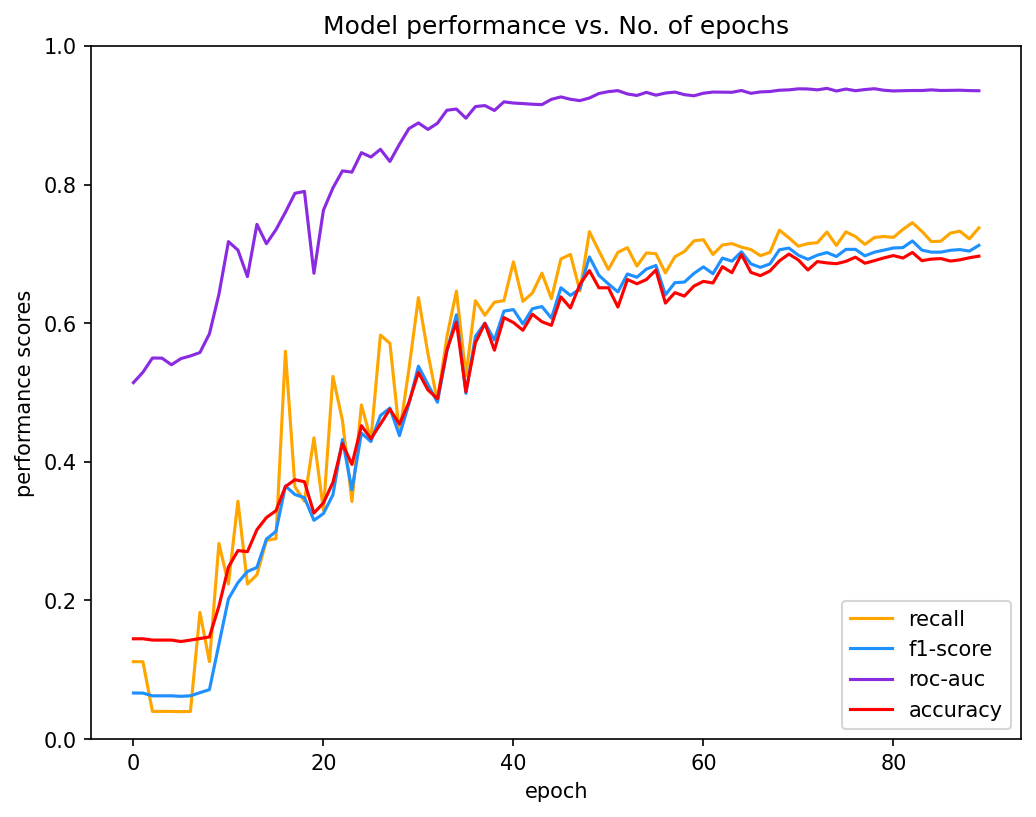

In [ ]:
plot_scores(results)

In [ ]:
def plot_lrs(lrs):
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Epoch')

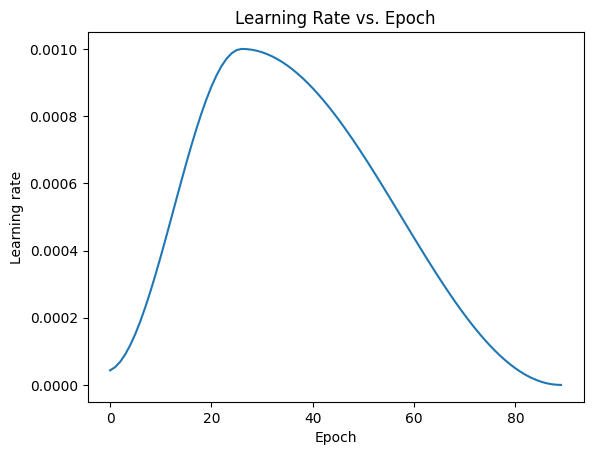

In [ ]:
plot_lrs(results['lr'])

In [ ]:
print(results)

{'acc': [0.14473684210526314, 0.14473684210526314, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14077163712200208, 0.14285714285714285, 0.14512471655328799, 0.1473922902494331, 0.1918243984038031, 0.24823446114381637, 0.27198427924251684, 0.2704149585551327, 0.30217065837150797, 0.31970044722413726, 0.3295249002329235, 0.3643600852443348, 0.3742627821551015, 0.3713617655975865, 0.32609325138794437, 0.34082564933685233, 0.37038564296562887, 0.4263903906869873, 0.3962859323375603, 0.4521941350496426, 0.43344913639044397, 0.45451042050859713, 0.4760151948256281, 0.45447586351365904, 0.4858263978315732, 0.5290911340551744, 0.5038761458310216, 0.4912287141066663, 0.5616778187818503, 0.6015563365311483, 0.5012630841483985, 0.571935673830816, 0.5998003094560806, 0.5612132851548911, 0.608213826161206, 0.601036115761353, 0.5899589821134539, 0.6130138324174613, 0.602239451075043, 0.5970510934217945, 0.6380928022410932, 0.6221431823256028, 0.6561775411936103, 0.676045887819110

In [ ]:
# model = EfficientNet(inverted_residual_setting, 0.2, last_channel=last_channel)
# model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/efficientnet.pt'))
# model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7286 , roc: 0.9485 , f1: 0.7235 , recall: 0.7637
